# Early Warning Models for Financial Crisis using Machine Learning Techniques

### Yelebe Desta and Seth Tenberg

# Lit Review

# Cleaning the Data

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm


In [2]:
data = pd.read_excel("/Users/yelebedesta/Downloads/JSTdatasetR6.xlsx")

# Exploring the Data

In [3]:
data.describe()

,year,ifs,pop,rgdpmad,rgdpbarro,rconsbarro,gdp,iy,cpi,ca,...,eq_capgain,eq_dp,eq_capgain_interp,eq_tr_interp,eq_dp_interp,bond_rate,eq_div_rtn,capital_tr,risky_tr,safe_tr
count,2718.00000,2718.000000,2667.000000,2666.000000,2664.000000,2561.000000,2.641000e+03,2425.000000,2.666000e+03,2.489000e+03,...,2.170000e+03,2169.000000,7.0,7.0,6.0,2381.000000,2163.000000,1830.000000,1854.000000,2247.000000
mean,1945.00000,148.333333,31439.397574,9155.064763,39.793748,42.133609,2.454826e+06,0.188838,4.191118e+01,-4.572271e+04,...,1.167935e+06,0.040949,1.0,1.0,1.0,0.054346,0.042763,0.099308,0.111523,0.051634
std,43.59701,24.165940,45898.993728,7976.190143,33.884462,32.274402,1.615548e+07,0.064621,5.689962e+01,7.670287e+05,...,5.440622e+07,0.017111,0.0,0.0,0.0,0.031442,0.017694,0.090360,0.110373,0.048357
min,1870.00000,111.000000,1675.000000,737.375497,3.263085,4.074400,1.250757e-11,0.017287,1.150362e-11,-1.687900e+07,...,-8.842261e-01,0.000000,1.0,1.0,1.0,-0.035316,0.000000,-0.232140,-0.238515,-0.152371
25%,1907.00000,132.000000,4866.650000,2873.047663,12.694448,15.650000,5.428200e+01,0.140980,2.526395e+00,-6.345947e+01,...,-5.496224e-02,0.030100,1.0,1.0,1.0,0.036000,0.032112,0.047950,0.051188,0.024857
50%,1945.00000,143.000000,10113.530000,5477.011227,23.056114,27.846700,1.810926e+03,0.194356,1.050679e+01,-3.300000e-02,...,4.175594e-02,0.040665,1.0,1.0,1.0,0.046100,0.042530,0.090982,0.102568,0.043005
75%,1983.00000,172.000000,45077.000000,14619.435708,65.770534,68.720000,5.038345e+04,0.230288,7.617557e+01,1.788000e+01,...,1.568719e-01,0.051569,1.0,1.0,1.0,0.063500,0.053196,0.137372,0.159925,0.067896
max,2020.00000,193.000000,329239.715278,45887.569802,147.282620,120.431162,2.070466e+08,0.546975,2.268252e+02,5.885998e+06,...,2.534419e+09,0.127113,1.0,1.0,1.0,0.237154,0.138189,1.144161,1.281639,0.408514


We want to make a early warning indicator model, thus our dependent variable of interest is not when the crisis occurs, but a year or two *before* the crisis occurs. The dataset being used encodes the year that a crisis occurs; we can do a quick fix to create our binary dependent variable.

In [4]:
data['indicator'] = ((data['crisisJST'].shift(-1) == 1) | (data['crisisJST'].shift(-2) == 1)).astype(int)


Now we will remove the year of the crisis along with the following four years to remove post crisis bias, which has been shown to affect analysis in previous research.

In [5]:
crisis_rows = data[data['crisisJST'] == 1].index.tolist()
crisis_rows_incremented1 = [row + 1 for row in crisis_rows]
crisis_rows_incremented2 = [row + 2 for row in crisis_rows]
crisis_rows_incremented3 = [row + 3 for row in crisis_rows]
crisis_rows_incremented4 = [row + 4 for row in crisis_rows]

crisis_rows_df = pd.DataFrame(
    {'crisis_rows': crisis_rows,
     'crisis_rows_incremented1': crisis_rows_incremented1,
     'crisis_rows_incremented2': crisis_rows_incremented2,
     'crisis_rows_incremented3': crisis_rows_incremented3,
     'crisis_rows_incremented4': crisis_rows_incremented4})

rows_to_remove = pd.concat([crisis_rows_df[col] for col in crisis_rows_df.columns])

# Sort the values in the combined column
rows_to_remove = rows_to_remove.sort_values()
# remove the rows from the data to account for crisis bias
data = data.drop(data.index[rows_to_remove])
# we have removed 435 from the dataset

Now we wil account for extraordinary events in history, and remove the years during which World War 1, the Great Depression, and World War 2. Then we will also create two new variables for our analysis. We create a measure of global credit creation, and a measure for the global slope of the yield curve.

In [6]:
# we will create a variable the measures the slope of the yield curve, subtracting short term interest rates from long term interest rates
data['slope'] = (data['ltrate'] - data['stir'])
# removing years for WW1, WW2, and Great Depression
data_filtered = data[(data['year'] < 1914) | (data['year'] > 1918)]
data = data_filtered[(data_filtered['year'] < 1933) | (data_filtered['year'] > 1945)]
data['year']
# now we will create our global slope and credit variables
grouped = data.groupby('year')
data = grouped.apply(lambda x: x.assign(
    global_credit=x.loc[x['country'] != x['country'].iloc[0], 'tloans'].mean(),
    global_slope=x.loc[x['country'] != x['country'].iloc[0], 'slope'].mean()
))

# Ungroup
data= data.reset_index(drop=True)

#making Debt Servicing Ratio Variable
data['DSR'] = (data['tloans'] - (data['ltrate']/data['gdp']))

To ensure stationarity of the time series data, we will augment most of our variables. CPI, Real Consumption per Capita, Housing prices, Money Supply, Credit Supply, Investment, and current account are all converted into growth rates ratios of GDP. We also change Stock prices, Debt/GDP ratio, and Debt Servicing Ratio are all changed into one year rates of change. 

In [7]:
data_rate = data.groupby('country').apply(lambda group: 
    group.assign(
        cpi_rate = (group['cpi'] - group['cpi'].shift(1)) / group['cpi'].shift(1),
        rconsumption_rate = (group['rconsbarro'] - group['rconsbarro'].shift(1)) / group['rconsbarro'].shift(1),
        housing_rate = (group['hpnom'] - group['hpnom'].shift(1)) / group['hpnom'].shift(1),
        money_rate = (group['money'] - group['money'].shift(1)) / group['money'].shift(1),
        DSR_rate = (group['DSR'] - group['DSR'].shift(1)/ group['DSR'].shift(1)),
        credit_rate = (group['tloans'] / group['gdp'] - group['tloans'].shift(1) / group['gdp'].shift(1)),
        global_credit_rate = (group['global_credit'] / group['gdp'] - group['global_credit'].shift(1) / group['gdp'].shift(1)),
        ca_rate = (group['ca'] / group['gdp'] - group['ca'].shift(1) / group['gdp'].shift(1)),
        investment_rate = (group['iy'] - group['iy'].shift(1)),
        stock_rate =  (group['capital_tr'] - group['capital_tr'].shift(1)),
        debtgdp_rate = (group['debtgdp'] - group['debtgdp'].shift(1))
    )
).reset_index(drop=True)


In [8]:
columns_to_keep = ['cpi_rate', 'rconsumption_rate', 'housing_rate', 'money_rate', 'DSR_rate', 'credit_rate', 
                   'global_credit_rate', 'slope', 'global_slope','ca_rate', 'investment_rate', 'stock_rate', 'debtgdp_rate',  'lev', 'noncore', 'indicator']
data_subset = data_rate[columns_to_keep]

missing_rows = data_subset[data_subset.isnull().any(axis=1)]

# Print the number of rows with missing values
print("Number of rows with missing values:", len(missing_rows))

Number of rows with missing values: 950


In [9]:
# dropping all the rows with na's 
data_subset = data_subset.dropna()

In [66]:
# standardizing the data
X = data_subset.drop(columns=['indicator'])
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Convert the standardized array back to a DataFrame
X_standardized = pd.DataFrame(X_standardized, columns=X.columns)
y = data_subset['indicator']
X_standardized.head()

,cpi_rate,rconsumption_rate,housing_rate,money_rate,DSR_rate,credit_rate,global_credit_rate,slope,global_slope,ca_rate,investment_rate,stock_rate,debtgdp_rate,lev,noncore
0,0.201881,-0.360813,-0.652080,-0.436655,0.147522,-0.654988,-0.015064,-0.194538,-0.804990,0.061955,1.408468,-0.384497,-0.120645,1.407139,-0.794071
1,-0.261516,-0.029319,-0.656442,-0.598620,0.147522,0.098263,-0.015064,-0.181635,-0.852109,-0.501147,0.201038,0.086456,0.399111,1.417348,-0.767489
2,-0.821518,0.663119,-0.750580,-0.546395,0.147522,-0.622619,-0.015064,-0.051417,-0.825305,2.247694,-2.502742,-0.207658,-0.341809,1.266318,-0.728409
3,-0.403177,-0.216924,-0.575168,-0.279722,0.147522,-0.318556,-0.015064,-0.174400,-1.372852,2.025113,-0.598677,0.422199,0.105125,1.104951,-0.698360
4,-0.256875,-1.409564,-0.103857,-0.104969,0.147522,-0.586132,-0.015064,-0.343230,-2.197101,0.451962,0.278050,0.299199,-0.368536,0.988934,-0.706451


In [67]:
X_standardized = X_standardized.rename(columns={'cpi_rate' : 'CPI Rate', 'rconsumption_rate' : 'Consumption Rate', 'housing_rate' : 'Housing Rate', 'money_rate' : 'Money Rate', 'DSR_rate' : 'DSR Rate',
                      'credit_rate' : 'Credit Rate', 'ca_rate' : 'CA Rate', 'investment_rate' : 'Investment Rate', 'stock_rate' : 'Stock Rate', 'debtgdp_rate' : 'Debt/GDP Rate',
                      'slope' : 'Slope', 'global_slope': 'Global Slope', 'global_credit_rate' : 'Global Credit Rate','lev' : 'Leverage', 'noncore' : 'Noncore'})
X_standardized.head()

,CPI Rate,Consumption Rate,Housing Rate,Money Rate,DSR Rate,Credit Rate,Global Credit Rate,Slope,Global Slope,CA Rate,Investment Rate,Stock Rate,Debt/GDP Rate,Leverage,Noncore
0,0.201881,-0.360813,-0.652080,-0.436655,0.147522,-0.654988,-0.015064,-0.194538,-0.804990,0.061955,1.408468,-0.384497,-0.120645,1.407139,-0.794071
1,-0.261516,-0.029319,-0.656442,-0.598620,0.147522,0.098263,-0.015064,-0.181635,-0.852109,-0.501147,0.201038,0.086456,0.399111,1.417348,-0.767489
2,-0.821518,0.663119,-0.750580,-0.546395,0.147522,-0.622619,-0.015064,-0.051417,-0.825305,2.247694,-2.502742,-0.207658,-0.341809,1.266318,-0.728409
3,-0.403177,-0.216924,-0.575168,-0.279722,0.147522,-0.318556,-0.015064,-0.174400,-1.372852,2.025113,-0.598677,0.422199,0.105125,1.104951,-0.698360
4,-0.256875,-1.409564,-0.103857,-0.104969,0.147522,-0.586132,-0.015064,-0.343230,-2.197101,0.451962,0.278050,0.299199,-0.368536,0.988934,-0.706451


In [11]:
# remova nas
#normalize data
# explore data
# make logistic model 

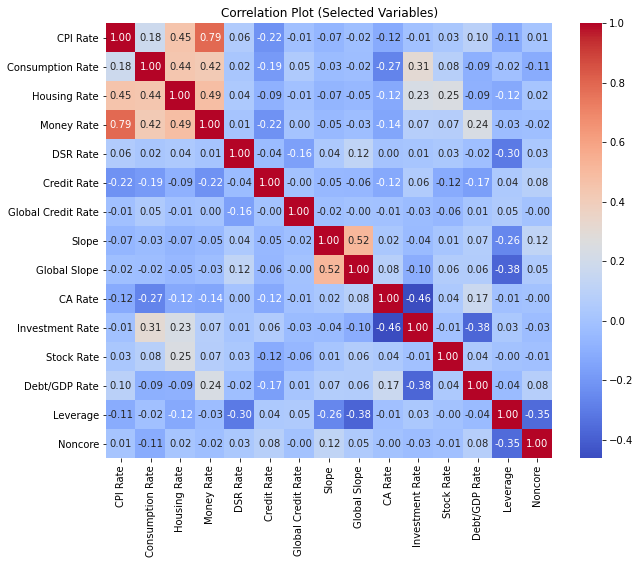

In [68]:
selected_variables = ['cpi_rate', 'rconsumption_rate', 'housing_rate', 'money_rate', 'DSR_rate',
                      'credit_rate', 'ca_rate', 'investment_rate', 'stock_rate', 'debtgdp_rate',
                      'slope', 'global_slope', 'global_credit_rate','lev', 'noncore']
numeric_data = X[selected_variables]

# Calculate correlation matrix
correlation_matrix = X_standardized.corr()

# Create Seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Plot (Selected Variables)')
plt.show()

While most variables are uncorrelated with one another, a few variables do have moderately strong relationships with our other explanatory variables. The CPI rate and the money supply growth rate have a very strong correlation (0.79). Noticably, the global and domestic slope variables have a correlation around 0.5. Our global and domestic variables appear to measure different things and are not highly correlated alternatives.

# Basic Logistic Model

To begin the analysis, we will construct a logistic model with all the variables included. This will serve as a baseline to reference for model performance. For analyze out-of-sample predictive performance, we will use a k-fold-crossfold validation method. Given the limited number of financial crises, splitting the data into a training and testing set would reduce predictive capabilities of the models. Previous research has shown that the two methods will perform comparably. We will use multiple methods to compare model performance. These methods include examining the *Receiver Operating Characteristic* space, Recall rate, and Shapley Values. These methods will be discussed later on.


In [88]:
X_standardized['intercept']=1.0
#y #1057
#X_standardized #1057
y = list(y)
logit = sm.Logit(y, X_standardized)
result=logit.fit()


result.summary()
coeff = result.params
coeff

Optimization terminated successfully.
         Current function value: 0.210866
         Iterations 9


CPI Rate             -0.577392
Consumption Rate     -0.499927
Housing Rate          0.320242
Money Rate           -0.237310
DSR Rate              0.024114
Credit Rate           0.573237
Global Credit Rate    0.121142
Slope                -0.557581
Global Slope         -0.541701
CA Rate               0.024734
Investment Rate       0.262959
Stock Rate           -0.307963
Debt/GDP Rate        -0.302594
Leverage              0.247515
Noncore               0.546485
intercept            -3.361010
dtype: float64

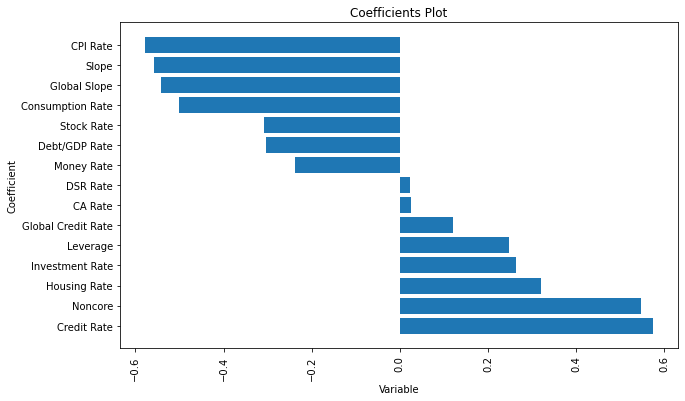

In [128]:
coefficients = result.params
coefficients = coefficients.drop(['intercept'])
coef_names = coefficients.index

sorted_coefficients = sorted(zip(coefficients, coef_names), reverse=True)
sorted_coefficients, sorted_coef_names = zip(*sorted_coefficients)


plt.figure(figsize=(10, 6))
plt.barh(sorted_coef_names, sorted_coefficients)
plt.xlabel('Variable')
plt.ylabel('Coefficient')
plt.title('Coefficients Plot')
plt.xticks(rotation=90)
plt.show()


<AxesSubplot:ylabel='Feature'>

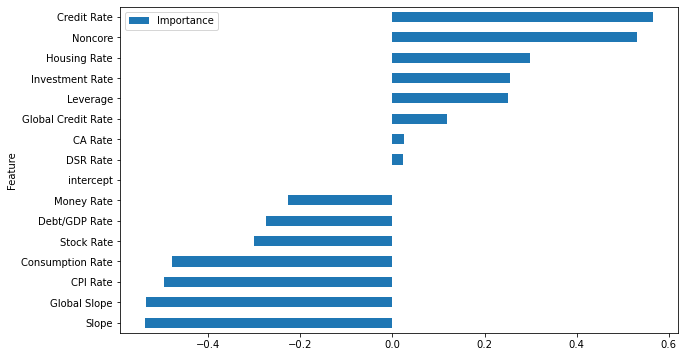

In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance


model = LogisticRegression()
model.fit(X_standardized, y)


#feature_importance = pd.DataFrame({'Feature': X_standardized.columns, 'Importance':(coefficients)})
#feature_importance = feature_importance.sort_values('Importance', ascending=True)
#feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))


This chart illusrtates the most important feautures in our logistic model. As seen above, the most important features are Credit Rate, Global and Domestic slope of the yield curve and Noncore funding.  

# ML technique - Lasso  

0.001


<BarContainer object of 15 artists>

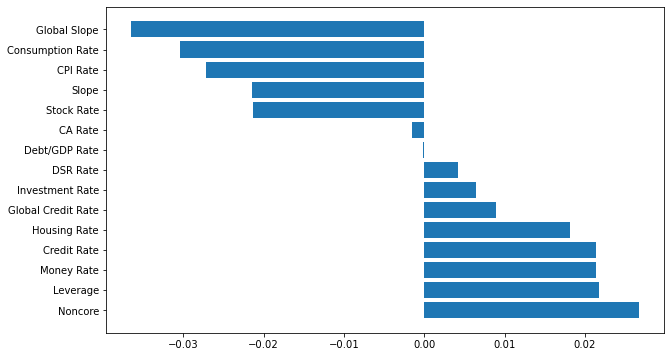

In [169]:
from sklearn.linear_model import LinearRegression, Lasso
# model evaluation
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV

lasso = Lasso()
param_grid = {'alpha' :[0.001, 0.01, 0.1, 1, 10]}
grid_search = GridSearchCV(estimator = lasso, param_grid=param_grid, cv=5)
grid_search.fit(X_standardized, y)

best_alpha = grid_search.best_params_['alpha']
print(best_alpha)
lasso_best = Lasso(alpha=best_alpha)
lasso_best.fit(X_standardized, y)


coeff_lasso = lasso_best.coef_
columns = ['Lasso_Coefficient', 'Feature']
new_df = pd.DataFrame(X_standardized.columns,coeff_lasso)





data = {'coeff_lasso': coeff_lasso, 'column_names': X_standardized.columns}

# Create DataFrame
df = pd.DataFrame(data)

df = df.drop(df.index[-1])

df = df.sort_values(by = 'coeff_lasso', ascending = False)

#new_df.drop(new_df.index[-1], inplace = True)


#columns = ['Lasso_Coefficient', 'Feature']
#new_df = pd.DataFrame(new_df, columns = columns)

plt.figure(figsize = (10,6))
plt.barh(df['column_names'], df['coeff_lasso'])
#new_df

#feature_importance_Lasso = lasso_best.feature_importances_

#feature_importance = pd.DataFrame({'Feature': X_standardized.columns, 'Importance': np.abs(coefficients)})
#feature_importance = feature_importance.sort_values('Importance', ascending=True)
#feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

# ML technique two etc

# showcase prediction capabilities and compare